In [1]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Create SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
# Load Data
data = spark.read.option('inferSchema', 'true').csv('Clustering.csv', header=True)
# data.show()

In [4]:
# Select Feature
data = data.select('Oil Concentration', 'Bacteria Level', 'Trash Pollution')
# data.show()

In [5]:
# Preprocess Data
data = data.na.drop()

In [6]:
# Transform

def transformRep(df):
    df = df.withColumn("Trash Pollution", when(df["Trash Pollution"] == "Low", 0.0)\
                       .when(df["Trash Pollution"] == "Medium", 1.0)\
                       .when(df["Trash Pollution"] == "High", 2.0))
    return df

def transformCast(df):
    df = df.withColumn('Trash Pollution', df['Trash Pollution'].cast('double'))
    df = df.withColumn('Oil Concentration', df['Oil Concentration'].cast('double'))
    df = df.withColumn('Bacteria Level', df['Bacteria Level'].cast('double'))
    return df

data = transformRep(data)
data = transformCast(data)
data = data.filter(((col('Oil Concentration')) != 0.0) &
                   ((col('Bacteria Level')) != 0.0) &
                   ((col('Trash Pollution')) != 0.0))
# data.show()

In [7]:
# Normalize
cols = data.columns
vectorAssembler = VectorAssembler(inputCols=cols, outputCol='AssembledFeatures')
vector = vectorAssembler.transform(data)
standardScaler = StandardScaler(inputCol='AssembledFeatures', outputCol='features').fit(vector)
data = standardScaler.transform(vector)

In [8]:
# Generate Model
model = KMeans().setK(2).setSeed(123).fit(data)

# Use Model
predictions = model.transform(data)

[]

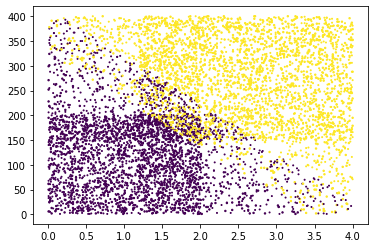

In [9]:
prediction_pd = predictions.toPandas()
plt.scatter(prediction_pd['Oil Concentration'],
            prediction_pd['Bacteria Level'],
            prediction_pd['Trash Pollution'],
            c=prediction_pd['prediction'])
plt.plot()